<a href="https://colab.research.google.com/github/jiaminho/RPH-HAC-Prediction/blob/main/HAC_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hospital Acquired Complications (HACs) Model Training and Evaluation

In [1]:
# mount google drive for google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path_prefix = '/content/drive/My Drive/CITS5553 Capstone Project/Capstone Project - HAC/hacks_project/'

Import libraries

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
pd.set_option('display.max_columns', None)  # None ensures all columns are shown
warnings.simplefilter(action='ignore', category=FutureWarning)

Read pre-processed data "all_encoded_df"

In [4]:
selected_features_df = pd.read_csv(path_prefix + 'data/selected_features_df.csv')
selected_features_df.shape

(58976, 1001)

In [5]:
selected_features_df

DIAGNOSIS_HEMATOMA  DIAGNOSIS_ADENOPATHY  \
0                       0                     0   
1                       0                     0   
2                       0                     0   
3                       0                     0   
4                       0                     0   
...                   ...                   ...   
58971                   0                     0   
58972                   0                     0   
58973                   0                     0   
58974                   0                     0   
58975                   0                     0   

       DIAGNOSIS_PNEUMONIA;LIVER FAILURE;RENAL FAILURE  LANGUAGE_*YID  \
0                                                    0              0   
1                                                    0              0   
2                                                    0              0   
3                                                    0              0   
4                                                    0              0   
...                                                ...            ...   
58971                                                0              0   
58972                                                0              0   
58973                                                0              0   
58974                                                0              0   
58975                                                0              0   

       RELIGION_ROMANIAN EAST. ORTH  DIAGNOSIS_BACTEREMIA  \
0                                 0                     0   
1                                 0                     0   
2                                 0                     0   
3                                 0                     0   
4                                 0                     0   
...                             ...                   ...   
58971                             0                     0   
58972                             0                     0   
58973                             0                     0   
58974                             0                     0   
58975                             0                     0   

       Open red-int fix humerus  DIAGNOSIS_? BOWEL OBSTRUCTION  \
0                           0.0                              0   
1                           0.0                              0   
2                           0.0                              0   
3                           0.0                              0   
4                           0.0                              0   
...                         ...                            ...   
58971                       0.0                              0   
58972                       0.0                              0   
58973                       0.0                              0   
58974                       0.0                              0   
58975                       0.0                              0   

       CLOSTRIDIUM PERFRINGENS  Closed nasal sinus bx  Suture of vein  \
0                          0.0                    0.0             0.0   
1                          0.0                    0.0             0.0   
2                          0.0                    0.0             0.0   
3                          0.0                    0.0             0.0   
4                          0.0                    0.0             0.0   
...                        ...                    ...             ...   
58971                      0.0                    0.0             0.0   
58972                      0.0                    0.0             0.0   
58973                      0.0                    0.0             0.0   
58974                      0.0                    0.0             0.0   
58975                      0.0                    0.0             0.0   

       Pericardial biopsy  Opn transv colon res NEC  Opn/oth part gastrectomy  \
0                     0.0        

In [6]:
selected_features_df['uti'] = selected_features_df['uti'].replace({True: 1, False: 0})

train test split

In [7]:
X = selected_features_df.drop('uti', axis=1)
y = selected_features_df['uti']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Scale data
scaler_original = StandardScaler()
X_train_scaled = scaler_original.fit_transform(X_train)
X_test_scaled = scaler_original.transform(X_test)

train val split

In [9]:
X_train_scaled, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

## Deep Neural Network (DNN)

In [20]:
# Adjust class weight
# class_weight_0 = len(y_train) / (2 * np.sum(y_train == 0))
# class_weight_1 = len(y_train) / (2 * np.sum(y_train == 1))
# class_weights = {0: class_weight_0, 1: class_weight_1}

from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Performance Scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)


model = Sequential()
model.add(Dense(64, input_shape=(X_train_scaled.shape[1],), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, sample_weight=sample_weights, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
590/590 [==============================] - 4s 4ms/step - loss: 0.5514 - accuracy: 0.6704 - val_loss: 0.4949 - val_accuracy: 0.7276 - lr: 0.0010
Epoch 2/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4368 - accuracy: 0.7631 - val_loss: 0.4581 - val_accuracy: 0.7613 - lr: 0.0010
Epoch 3/100
590/590 [==============================] - 2s 4ms/step - loss: 0.3917 - accuracy: 0.7907 - val_loss: 0.4219 - val_accuracy: 0.7790 - lr: 0.0010
Epoch 4/100
590/590 [==============================] - 2s 4ms/step - loss: 0.3650 - accuracy: 0.7986 - val_loss: 0.4329 - val_accuracy: 0.7855 - lr: 0.0010
Epoch 5/100
590/590 [==============================] - 2s 4ms/step - loss: 0.3440 - accuracy: 0.8139 - val_loss: 0.4344 - val_accuracy: 0.7927 - lr: 0.0010
Epoch 6/100
590/590 [==============================] - 2s 4ms/step - loss: 0.3196 - accuracy: 0.8258 - val_loss: 0.4861 - val_accuracy: 0.7864 - lr: 0.0010
Epoch 7/100
590/590 [==============================] - 2s 4ms/st

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                64064     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                

Plot Learning Curves

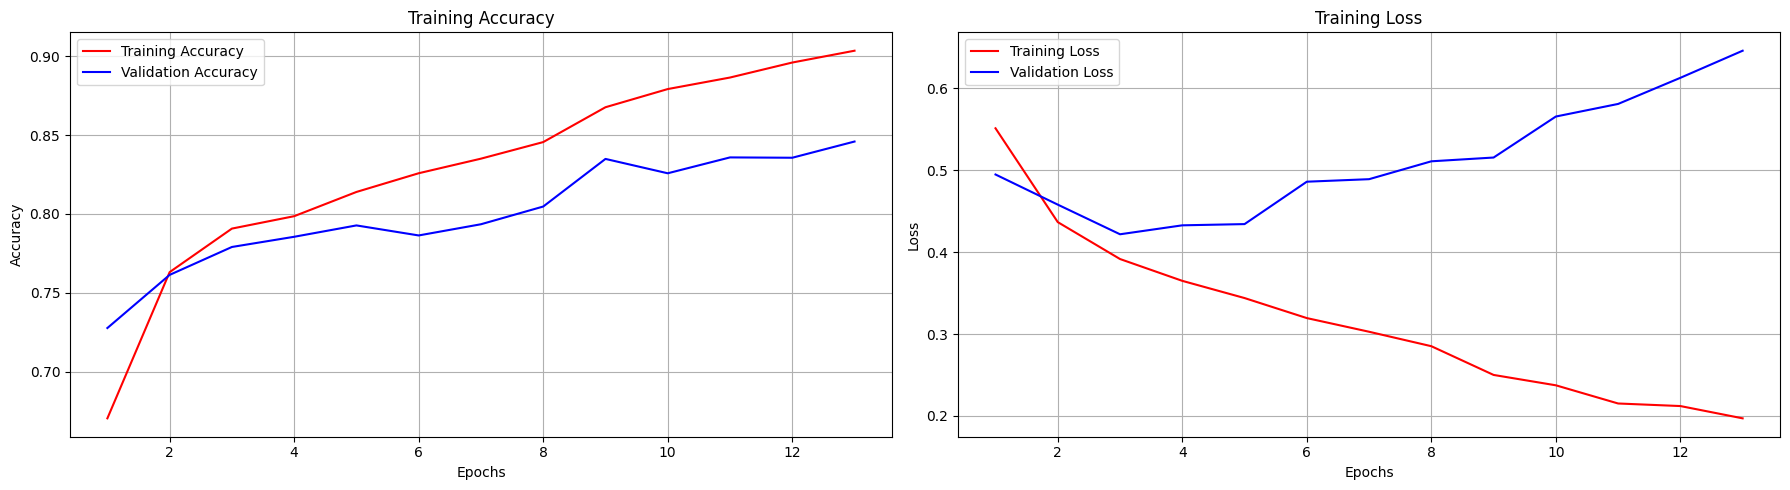

In [22]:
def plot_learning_curves(history):
    # Extract the training and validation losses & accuracies
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(18, 5))

    # Plot training and validation accuracies
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot training and validation losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

**DNN Model Evaluation**

In [23]:
# train and test predictions
dnn_y_test_pred = model.predict(X_test_scaled)
dnn_y_train_pred = model.predict(X_train_scaled)

1180/1180 [==============================] - 2s 1ms/step


In [24]:
print(classification_report(y_test, dnn_y_test_pred.round()))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86     10565
           1       0.29      0.80      0.43      1231

    accuracy                           0.78     11796
   macro avg       0.63      0.79      0.65     11796
weighted avg       0.90      0.78      0.82     11796



In [25]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

78.86% - Balanced accuracy Test
86.71% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

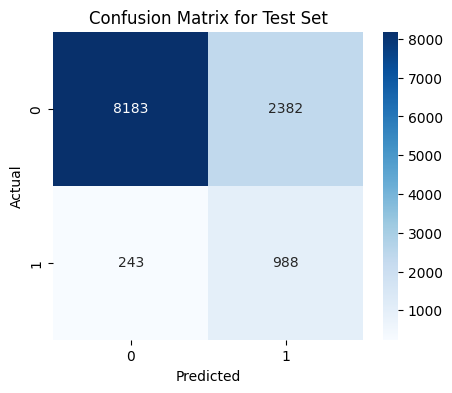

In [26]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, dnn_y_test_pred.round())
#train_cm = confusion_matrix(y_train, dnn_y_train_pred.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [64]:
rf_y_pred = rf.predict(X_test_scaled)
rf_y_train_pred = rf.predict(X_train_scaled)
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     10565
           1       0.73      0.05      0.09      1231

    accuracy                           0.90     11796
   macro avg       0.82      0.52      0.52     11796
weighted avg       0.88      0.90      0.86     11796



In [65]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, rf_y_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, rf_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

52.22% - Balanced accuracy Test
100.00% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

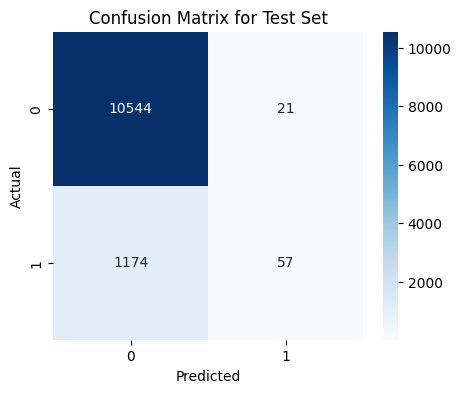

In [66]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, rf_y_pred.round())
train_cm = confusion_matrix(y_train, rf_y_train_pred.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

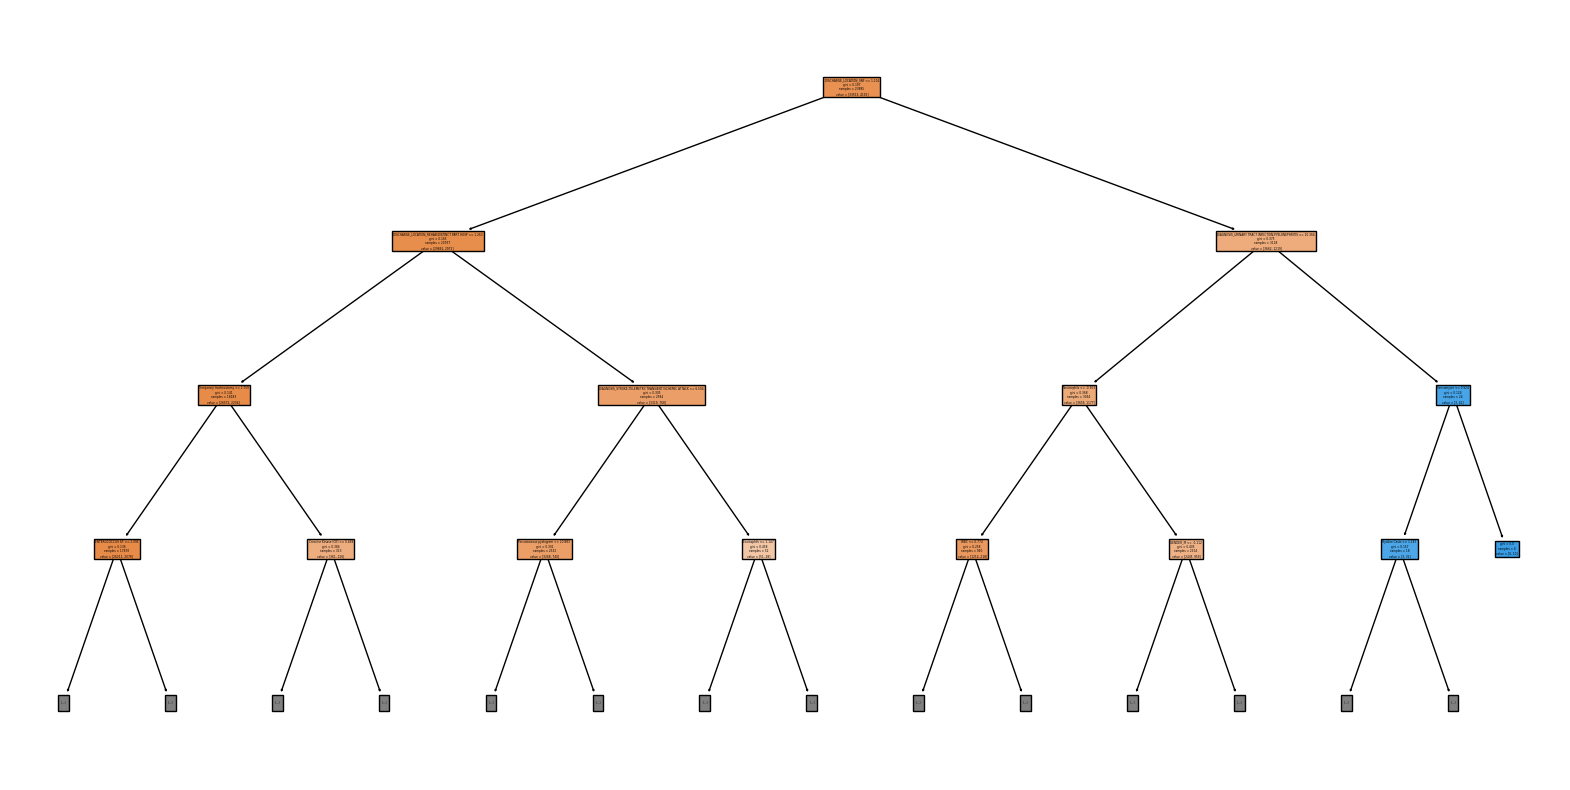

In [74]:
from sklearn.tree import plot_tree

# Visualizing the first decision tree
plt.figure(figsize=(20,10))
plot_tree(rf.estimators_[0], filled=True, max_depth=3, feature_names=X.columns)
plt.show()

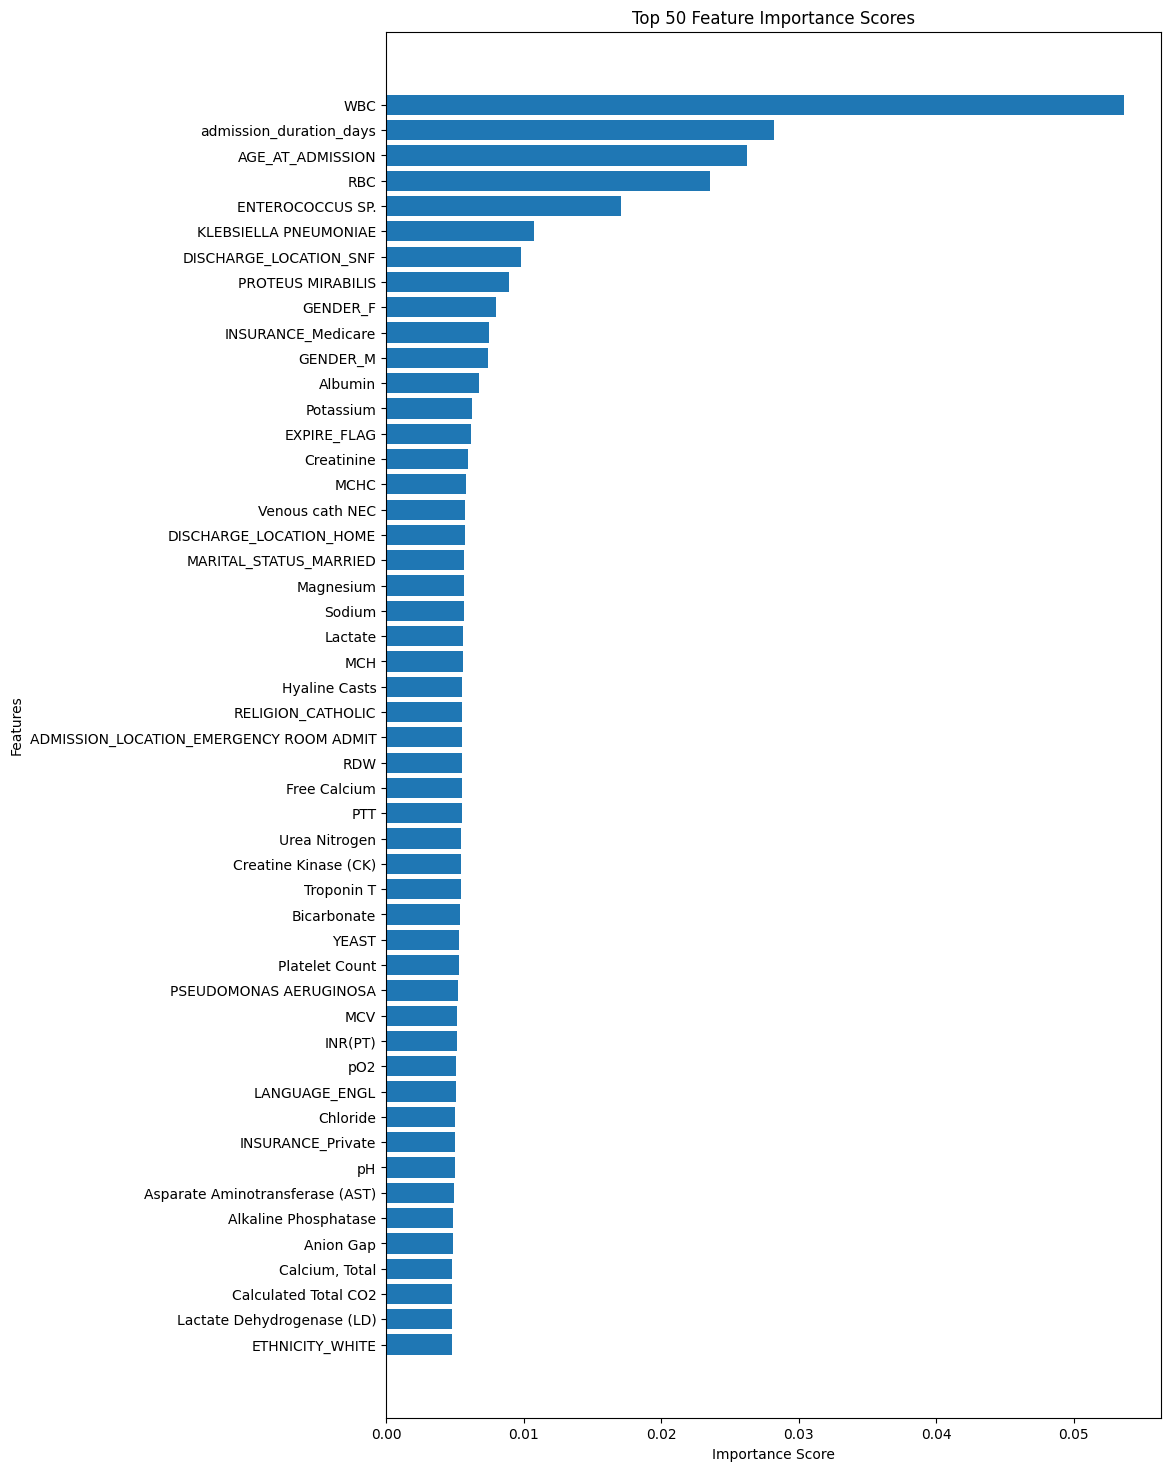

In [75]:
importances = rf.feature_importances_
features = X.columns

# Get the indices of the top 50 features
sorted_indices = np.argsort(importances)[-50:]

plt.figure(figsize=(10,18))
plt.barh(features[sorted_indices], importances[sorted_indices])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 50 Feature Importance Scores')
plt.show()


## XGBoost

In [67]:
import xgboost as xgb

# Create and train the model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# predict using test set
xgb_predictions = xgb_model.predict(X_test_scaled)
xgb_train_predictions = xgb_model.predict(X_train_scaled)

# show classification report
print("XGBoost Classification Report:\n")
print(classification_report(y_test, xgb_predictions))

XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     10565
           1       0.57      0.31      0.40      1231

    accuracy                           0.90     11796
   macro avg       0.75      0.64      0.67     11796
weighted avg       0.89      0.90      0.89     11796



In [68]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, xgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, xgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

64.08% - Balanced accuracy Test
74.97% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

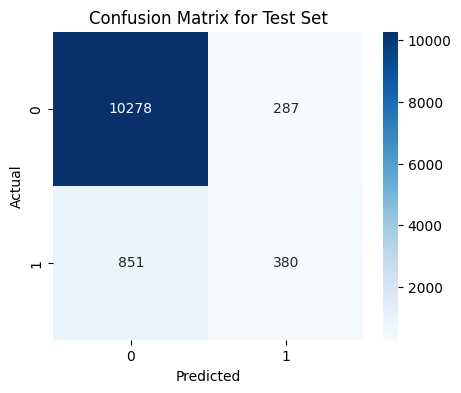

In [69]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, xgb_predictions.round())
train_cm = confusion_matrix(y_train, xgb_train_predictions.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## LightGBM

In [70]:
import lightgbm as lgb

# Create and train the model
lgb_model = lgb.LGBMClassifier(objective="binary", random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# predict using test set
lgb_predictions = lgb_model.predict(X_test_scaled)
lgb_train_predictions = lgb_model.predict(X_train_scaled)

# show classification report
print("LightGBM Classification Report:\n")
print(classification_report(y_test, lgb_predictions))

[LightGBM] [Info] Number of positive: 4220, number of negative: 33524
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2916
[LightGBM] [Info] Number of data points in the train set: 37744, number of used features: 864
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111806 -> initscore=-2.072426
[LightGBM] [Info] Start training from score -2.072426
LightGBM Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     10565
           1       0.59      0.28      0.38      1231

    accuracy                           0.90     11796
   macro avg       0.75      0.63      0.67     11796
weighted avg       0.89      0.90      0.89     11796



In [71]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, lgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, lgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

62.98% - Balanced accuracy Test
69.95% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

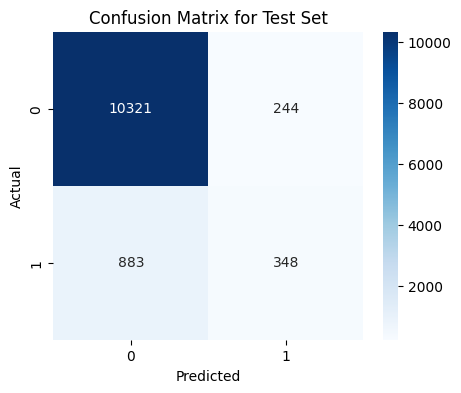

In [72]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, lgb_predictions.round())
train_cm = confusion_matrix(y_train, lgb_train_predictions.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')